# Generate a mosaic of the GOES-16 channels in Satpy and ImageMagick

In [1]:
from satpy import Scene, demo
from IPython.display import Image
import warnings
warnings.simplefilter("ignore")

Get the Hurricane Florence data from the demo module

In [2]:
filenames = demo.get_hurricane_florence_abi(num_frames=1)
scn = Scene(reader='abi_l1b', filenames=filenames)
channels = ['C{channel:02d}'.format(channel=chn) for chn in range(1, 17)]
scn.load(channels)
scn.save_datasets(filename='{name}.png')

Then we can use the ImageMagick command `montage` to join all the images together.

In [3]:
!montage C??.png -geometry 512x512+4+4 -background black montage_abi.jpg

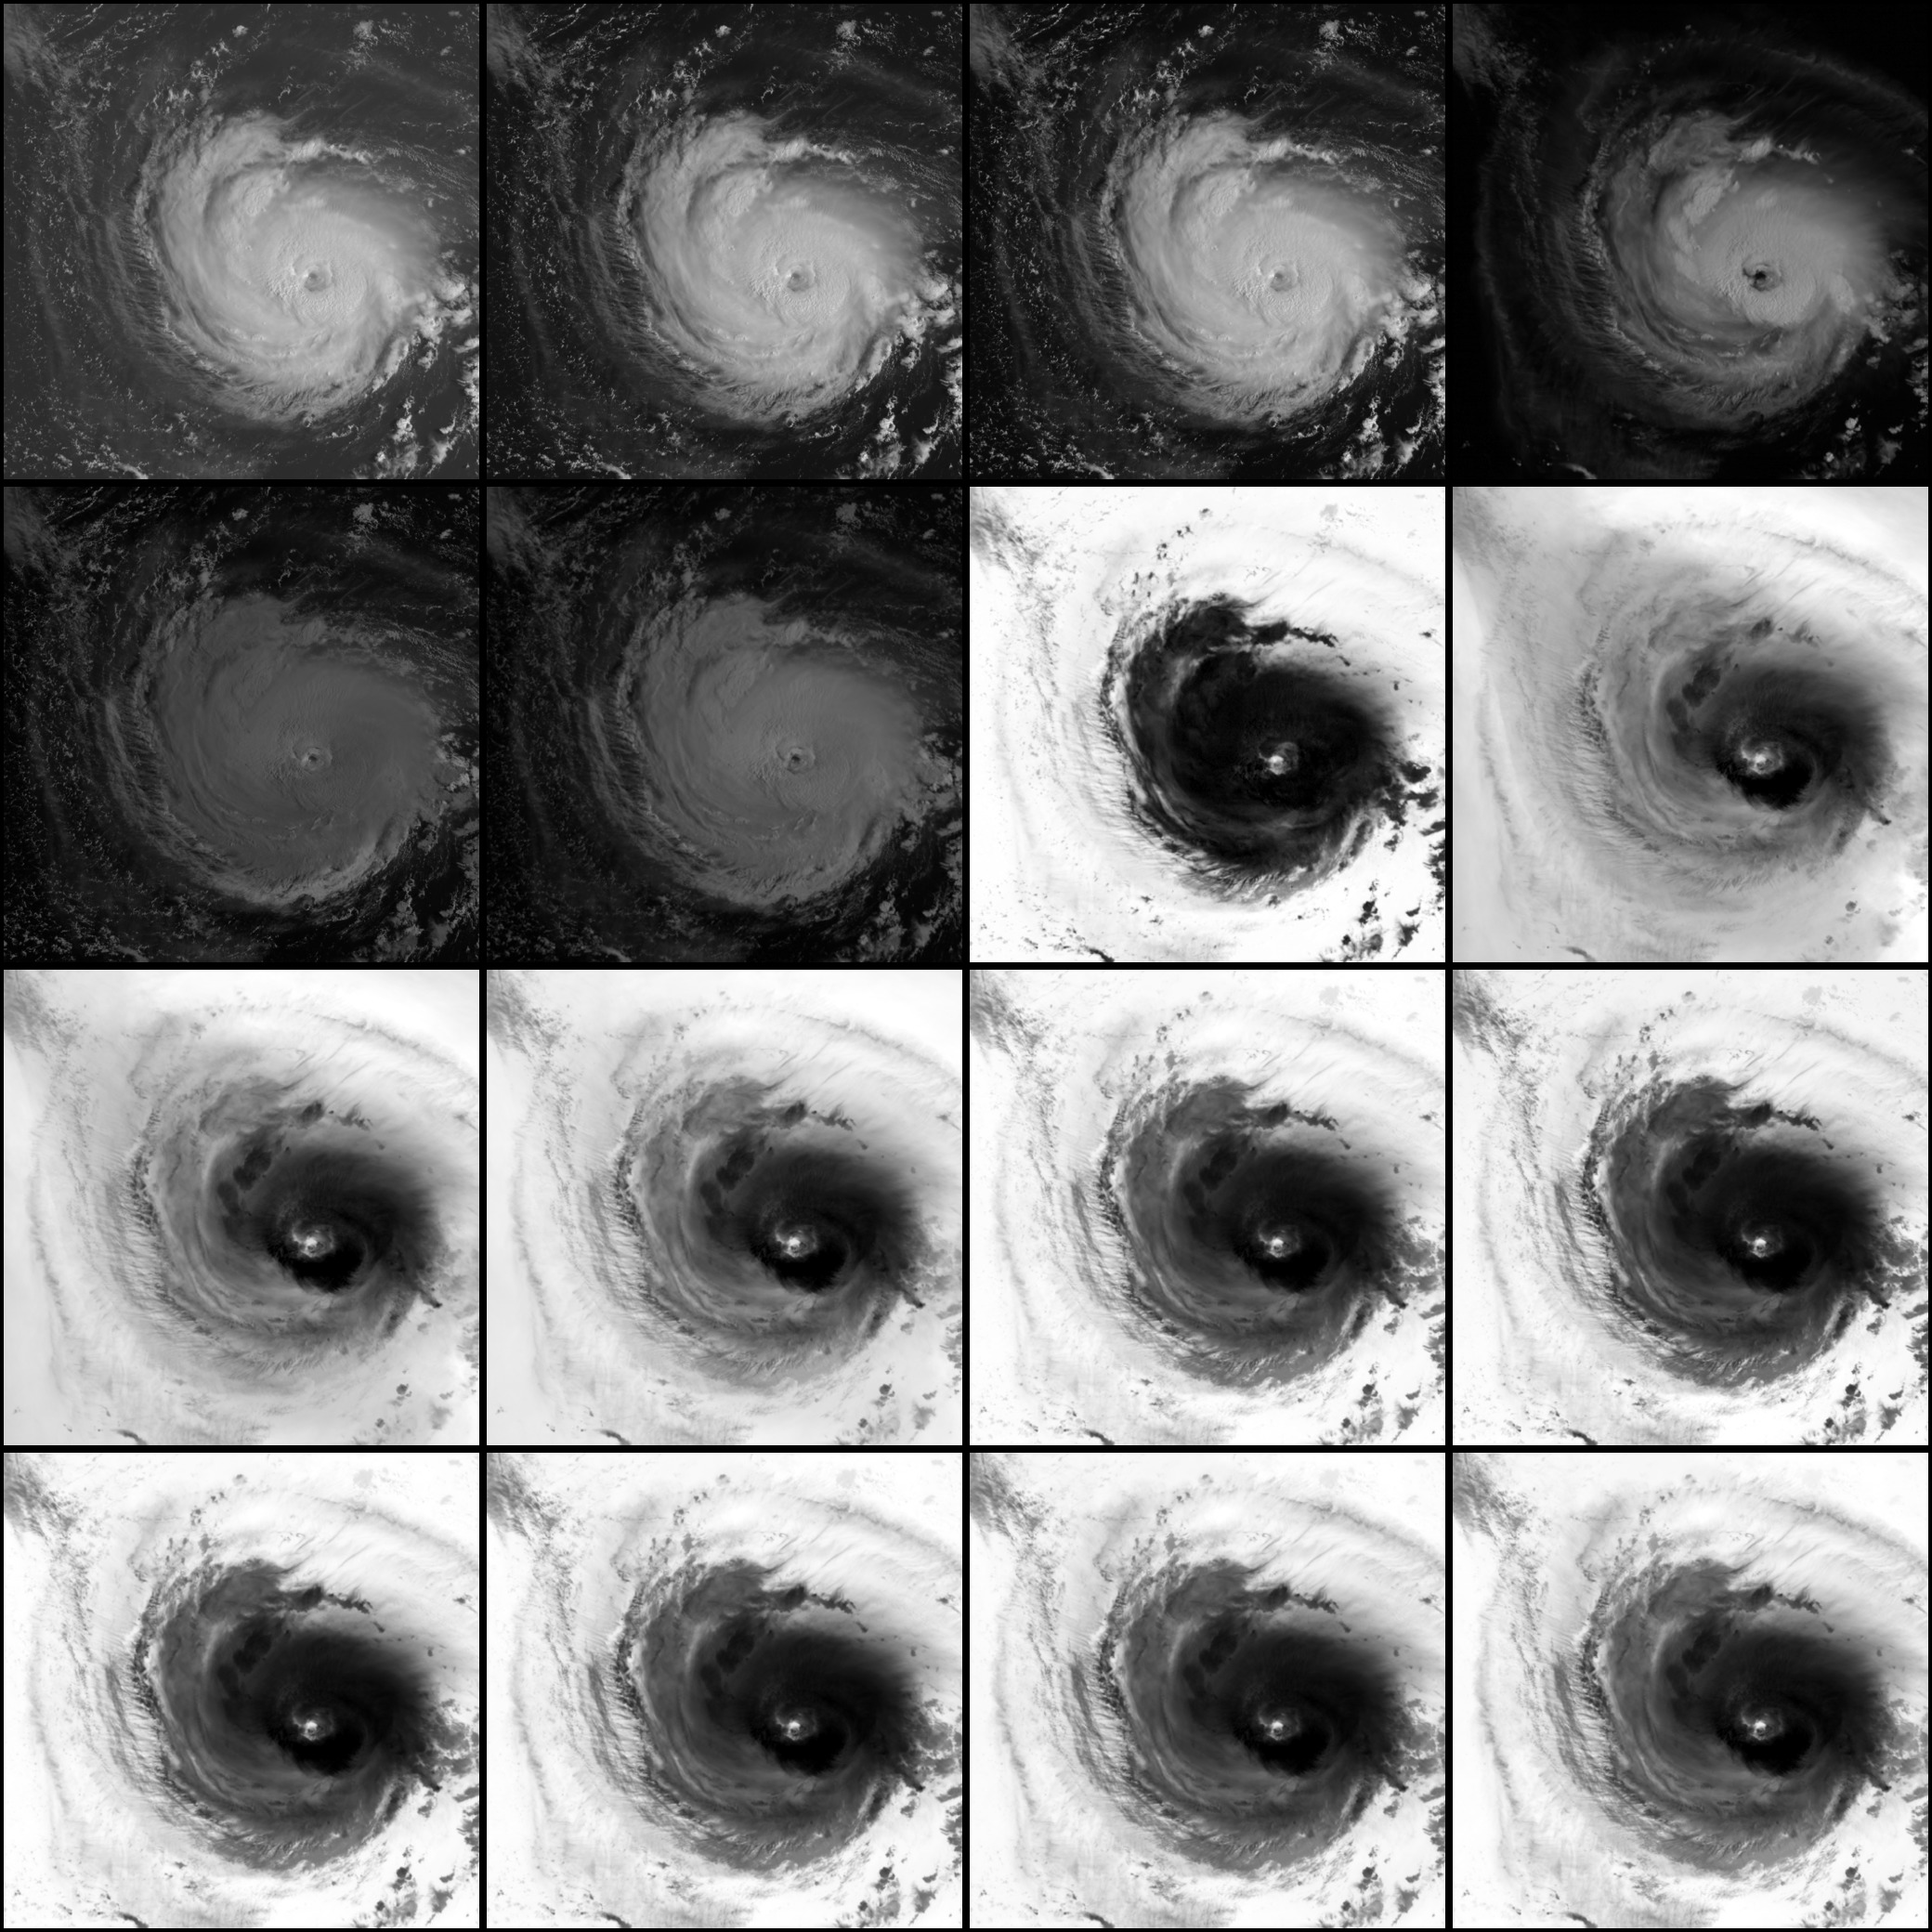

In [4]:
Image(filename='montage_abi.jpg') 